In [1]:
%run imports_notebook.py

Using device cuda


In [38]:
torch.manual_seed(4)
net = nn.Sequential(nn.Linear(1, 10), nn.GELU(), nn.Linear(10, 10), nn.GELU(), nn.Linear(10, 1))

In [39]:
x = torch.linspace(-10, 10, 1000)[:, None]
y = net(x)

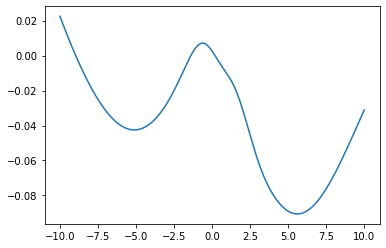

In [40]:
plt.plot(x[:, 0], y[:, 0].detach())

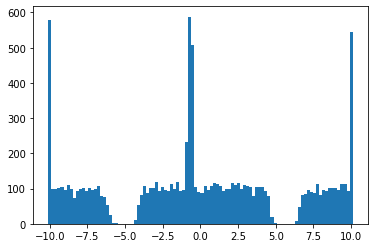

In [79]:
torch.manual_seed(0)
o = torch.rand(10000)*20-10
o.requires_grad_()

opt = torch.optim.Adam([o], lr=1e-1)

for _ in range(10):
    o.data.clip_(-10, 10)
    yo = net(o[:, None])
    loss = -yo.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

plt.hist(o.detach().numpy(), bins=100);

In [ ]:
seed = 0

use_wandb = False

batch_size = 128
load_factor = 100
np.random.seed(seed); torch.manual_seed(seed)

dcs = None
dcs = discrete_prob.DiscretizeContinuousSpace(np.full(3, fill_value=-1, dtype=float),
                                              np.full(3, fill_value=+1, dtype=float),
                                              [21, 21, 1])
predict_acceleration = False
if predict_acceleration:
    bounds = torch.tensor([30000] + [7000]*10)[:, None]
else:
    bounds = torch.tensor([constants.max_speed_ball] + [constants.max_speed_human]*10)[:, None]

n_bins_total = None if dcs is None else np.prod(dcs.n_bins)
bin_count = torch.zeros(n_bins_total).to(device)

# net = agent.ModelNet(mbd, n_outputs=(3 if dcs is None else n_bins_total),
#                      n_embed=210, n_heads=5, mlp_dim=400, n_layers=5).to(device)
net = agent.ModelNet(mbd, n_outputs=(3 if dcs is None else n_bins_total),
                     n_embed=750, n_heads=10, mlp_dim=1000, n_layers=8).to(device)
loss_cross_entropy = nn.CrossEntropyLoss()

print('# of Model Parameters: ', np.sum([p.numel() for p in net.parameters()]))
# for p in net.parameters():
    # p.data.uniform_(-1e-3, 1e-3)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

if use_wandb: wandb.init()

losses = []
pbar = tqdm(range(50))
for idx_epoch in pbar:
    for idx_batch, batch in enumerate(data.data_loader(batch_size=batch_size, load_factor=load_factor, tqdm=tqdm)):
        
        x = batch['x'].float().to(device)
        v = batch['v'].float().to(device)
        id_team = batch['id_team'].to(device)
        id_player = batch['id_player'].to(device)
        
        y_batch_pred = net.forward(x, v=v, id_team=id_team, id_player=id_player)
        
        if dcs is None:
            y = batch['nv'].to(device)
            loss = (y_batch_pred-y).pow(2.).mean()
        else:
            current = batch['a' if predict_acceleration else 'v']
            nextt = batch['na' if predict_acceleration else 'nv']
            y = dcs.vec2bin_torch(nextt/bounds).to(device) # gpu->cpu not needed
            py = dcs.vec2bin_torch(current/bounds).to(device) # gpu->cpu not needed
            
            bin_count[y.reshape(-1)] = bin_count[y.reshape(-1)] + 1
            
            loss = loss_cross_entropy(y_batch_pred.reshape(-1, n_bins_total), y.reshape(-1))
            ploss = loss_cross_entropy(y_batch_pred.reshape(-1, n_bins_total), py.reshape(-1))
            
            categorical = torch.distributions.Categorical(logits=y_batch_pred)
            entropy = categorical.entropy().detach().cpu().flatten().numpy()
            
            if use_wandb: wandb.log({'entropy': wandb.Histogram(entropy)}, commit=False)
            if use_wandb: wandb.log({'ploss': ploss.item()}, commit=False)
            
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())

        pbar.set_postfix({'loss': loss.item()})
        
        if use_wandb: wandb.log({'loss': loss.item()})
